Traing process and results of verifiable case 1.

The ground truth PDF:
$$
p(\theta_1,x_2)=\mathcal{N}(\theta_1|0,2^2)\times\mathcal{N}(\theta_2|\frac{1}{4}\theta_1^2,1)\, .
$$
We also show some methods for quantifying distributional differences.

In [1]:
import sys
sys.path.append('..')
from kmade.core import *
import torch
import os
import numpy as np
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#generate dataset
def generate_data(num_samples,seed=2024):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    theta1 = torch.normal(mean=0, std=2, size=(num_samples,))
    theta2 = torch.normal(mean=0.25 * theta1.pow(2), std=torch.ones_like(theta1))
    
    return torch.stack([theta1, theta2], dim=1).to(device)

train_data=generate_data(4000,seed=2024)
test_data=generate_data(4000,seed=2025)

#Use the data as a label in the loss function to compute u
dataset={'train_data':train_data,'test_data':test_data}

In [3]:
model=SGKMADE(data_l=2,hidden_layers=[],input_order='sequential',mode='random',grid=5,k=3,seed=2024,device=device,ckpt_path='./checkpoints');

checkpoint directory created: ./checkpoints
saving model version 0.0


In [4]:
model.fit(dataset=dataset,opt='Adam',steps=1000,lr=1e-2,loss_fn=loss_function,update_grid=True);

| train_loss: 3.50e+00 | test_loss: 3.53e+00 | reg: 1.01e+00 | : 100%|█| 1000/1000 [00:07<00:00, 132

saving model version 0.1


In [5]:
#save the model
os.makedirs('outputs', exist_ok=True)
model.saveckpt('outputs/experiment1')

In [6]:
#get symbolic representation of the model
model.auto_symbolic()

fixing (0,0,0) with 0
fixing (0,0,1) with x^2, r2=0.9983066320419312, c=2
fixing (0,0,2) with 0
fixing (0,0,3) with 0, r2=0.0, c=0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with 0
saving model version 0.2


In [7]:
#train again
results_ana=model.fit(dataset=dataset,opt='Adam',steps=500,lr=1e-3,loss_fn=loss_function,update_grid=True)

| train_loss: 3.51e+00 | test_loss: 3.52e+00 | reg: 0.00e+00 | : 100%|█| 500/500 [00:10<00:00, 46.80

saving model version 0.3


In [8]:
#save the expression
save_expr(model,path='outputs/experiment1')

In [9]:
#read expressions
read_expr(path='outputs/experiment1')

0.256189397736531*exp(-0.127812238266401*(x_1 - 0.0247243484554189)**2 - 0.513511134792953*(x_2 - 0.246316822803815*(-x_1 - 0.0215450742814701)**2 - 0.0282458598576003)**2)/pi**1.0

In [10]:
symbolic=True

if symbolic:
    sample_kmade=sampler(path='outputs/experiment1',n_samples=40000)
else:
    #load the saved model
    #model=load_model('outputs/experiment1')
    sample_kmade=model.sample(n_samples=40000).detach().cpu().numpy()

In [11]:
theta1=np.random.normal(0,2,size=40000)
theta2=np.array([np.random.normal(1/4*i**2,1) for i in theta1])
sample_true=np.column_stack((theta1,theta2))

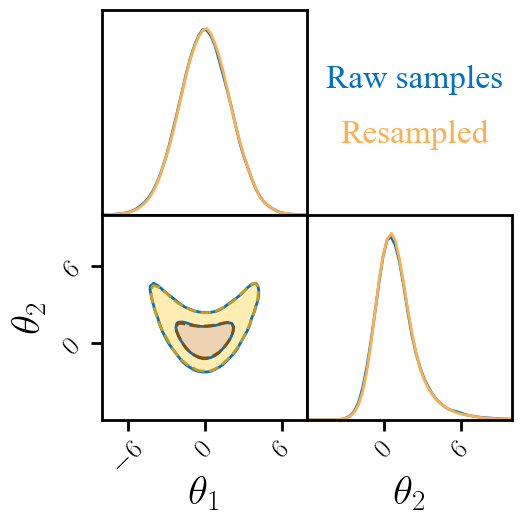

In [ ]:
#configuration of corner plots 
contour_kwargs={'colors1':['#0072C1'],
                'colors2':['#c39d21','#8d4e00'],
                'levels':[0.5,0.9],
                'width':[2,2],
                'linestyles':['-','--'],
                'smooth':1,
                'alphas':[1,0],}
contourf_kwargs={'colors':['white','#ffedb2','#edd3b2']}
hist_kwargs={'color':['#0072C1','#fcaf4d'],
             'width':[2,2],
             'linestyles':['-','-'],
             'alphas':[1,1],
             'bins':50,
             'smooth1d':1}
var_kwargs={'names':[r"$\theta_{1}$",r"$\theta_{2}$"],
            'ranges':[(-8,8),(-6,10)],
            'size':30,
            'pad':-0.03}
axes_kwargs_corner={'width':2,
             'length':8,
             'size':20,
             'color':'black',
             'rotationx':45,'rotationy':45,
             'max_n_ticks':3}
legend_kwargs_corner={'legends':['Raw samples','Resampled'],
              'locs':[(0.75,0.8),(0.75,0.7)],
              'size':24,
              'family':'Times New Roman',
              'weights':['normal','normal'],
              'ha':'center','va':'center'}
corner_plot(sample_true,sample_kmade,
            path='outputs/experiment1_sym.pdf' if symbolic else 'outputs/experiment1_nn.pdf',
            contour_kwargs=contour_kwargs,contourf_kwargs=contourf_kwargs,hist_kwargs=hist_kwargs,
            var_kwargs=var_kwargs,axes_kwargs=axes_kwargs_corner,legend_kwargs=legend_kwargs_corner)

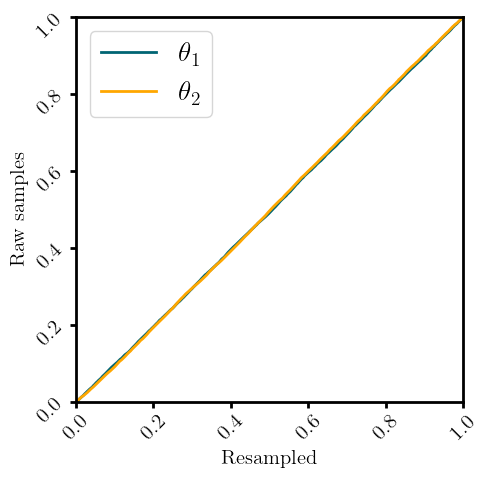

In [ ]:
#configuration of pp plots
legend_kwargs_pp={'loc':'best',
               'color':'black',
               'ls':[],
               'handlelength':2,
               'prop':{'size':20}}
title_kwargs={'content':'',
              'size':12,
              'color':'black',
              'family':'Times New Roman',
              'weight':'bold',
              'pad':0.05,
              'if_title':False}
label_kwargs={'labels':['Resampled','Raw samples'],
              'size':15,
              'family':'Times New Roman',
              'colors':['black','black']}
ref_kwargs={'color':'black',
             'width':2,
             'linestyle':'--',
             'alpha':1,
             'if_ref':False,}
axes_kwargs_pp={'width':2,
             'size':15,
             'weight':'normal',
             'length':4,
             'color':'black',
             'rotationx':45,'rotationy':45,
             'max_n_ticks':3}
pp_plot(color_bar=['#006573','#FFA700'],
        column_names=[r"$\theta_{1}$",r"$\theta_{2}$"],
        sample_lw=2,
        path='outputs/experiment1_sympp.pdf' if symbolic else 'outputs/experiment1_nnpp.pdf',
        sample1=sample_true,sample2=sample_kmade,
        axes_kwargs=axes_kwargs_pp,
        legend_kwargs=legend_kwargs_pp,
        title_kwargs=title_kwargs,
        label_kwargs=label_kwargs,
        ref_kwargs=ref_kwargs)

**Some Methods to quantify the difference**

In [15]:
# data preparation
# samples from the model
sample1=model.sample(n_samples=2000)
likelihood1=model.likelihood(sample1,log=False)
sample1=sample1.detach().cpu().numpy()
# true samples
theta1=np.random.normal(0,2,size=2000)
theta2=np.array([np.random.normal(1/4*i**2,1) for i in theta1])
sample2=np.column_stack((theta1,theta2))
likelihood2=torch.tensor(1/2*np.pi*np.exp(-0.5*(theta1/2)**2-0.5*(theta2-1/4*theta1**2)**2)).to(likelihood1.device,likelihood1.dtype)

In [16]:
#MMD
mmd_value = MMD(sample1, sample2)
print(f"MMD: {mmd_value.item()}")

MMD: 0.0011918568105247168


In [17]:
# KL Divergence
kl_div=kl_divergence(likelihood1,likelihood2)
print(f"KL Divergence: {kl_div.item()}")

KL Divergence: -203.44508361816406


In [18]:
# JS Divergence
js_div=js_divergence(likelihood1,likelihood2)
print(f"JS Divergence: {js_div.item()}")

JS Divergence: 429.93994140625
